In [2]:
pip install d3rlpy


     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
     -------------- ------------------------- 262.1/721.7 kB ? eta -:--:--
     -------------- ------------------------- 262.1/721.7 kB ? eta -:--:--
     -------------------------- --------- 524.3/721.7 kB 837.5 kB/s eta 0:00:01
     ------------------------------------ 721.7/721.7 kB 840.1 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/958.1 kB ? eta -:--:


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install gymnasium


[notice] A new release of pip is available: 24.3.1 -> 25.3

[notice] To update, run: python.exe -m pip install --upgrade pip

In [6]:
import gymnasium as gym
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import classification_report, confusion_matrix
import d3rlpy
from d3rlpy.algos import CQLConfig
from d3rlpy.dataset import MDPDataset
from d3rlpy.metrics import TDErrorEvaluator, EnvironmentEvaluator
import warnings
warnings.filterwarnings('ignore')

In [8]:
print("Loading data...")
# We need the original (unscaled) data to calculate rewards
train_df = pd.read_csv('C:/Users/AKANKSHA SINHA/Desktop/Shodhai/data/processed/train.csv')
test_df = pd.read_csv('C:/Users/AKANKSHA SINHA/Desktop/Shodhai/data/processed/test.csv')

# Load original loan data to get loan_amnt and int_rate
# These were scaled, so we need the original values
original_train = pd.read_csv('C:/Users/AKANKSHA SINHA/Desktop/Shodhai/data/raw/accepted_2007_to_2018Q4.csv', nrows=500000)

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Loading data...
Train shape: (273973, 45)
Test shape: (58676, 45)


Processing training data...
Created RL dataset with 273973 samples

Reward statistics:
  Mean reward: $-1,507.66
  Median reward: $1,183.50
  Min reward: $-35,000.00
  Max reward: $10,146.50
  Std reward: $7,997.29

Saved: rl_reward_distribution.png


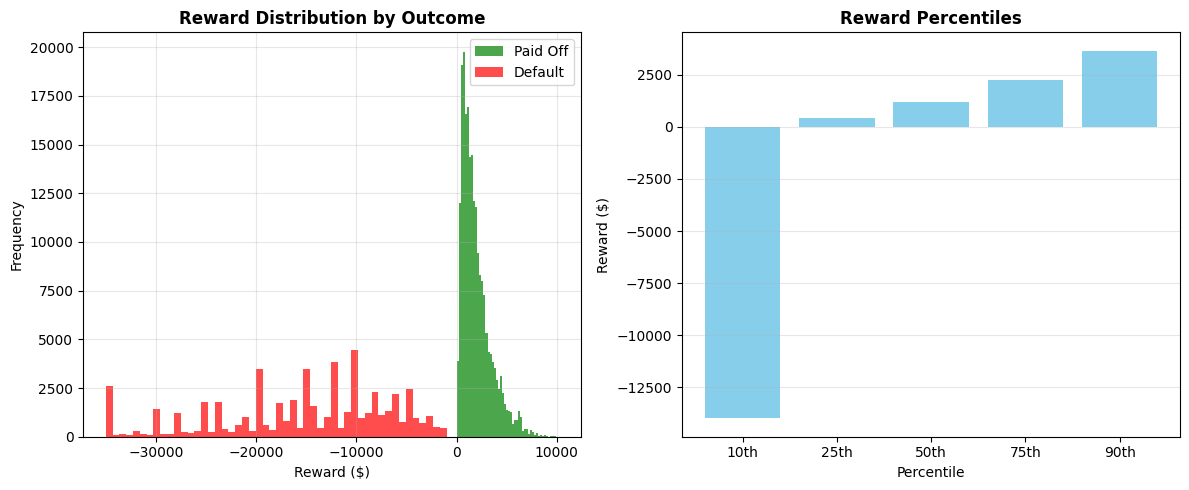

In [10]:
def create_rl_dataset(df, original_df, loan_amount_col='loan_amnt', interest_rate_col='int_rate'):
    """
    Create an offline RL dataset from loan data.
    
    State: Feature vector for each loan application
    Action: 1 (Approve) - all loans in dataset were approved
    Reward: Financial outcome based on loan performance
    """
    
    # Separate features and target
    X = df.drop('target', axis=1).values
    y = df['target'].values
    
    # Match by index (assuming same order)
    loan_amounts = original_df[loan_amount_col].iloc[:len(df)]
    loan_amounts = pd.to_numeric(loan_amounts, errors='coerce').fillna(0).values
    
    # Handle interest rate robustly
    ir_raw = original_df[interest_rate_col].iloc[:len(df)]
    ir_clean = ir_raw.astype(str).str.rstrip('%')
    interest_rates = pd.to_numeric(ir_clean, errors='coerce').fillna(0).values / 100.0
    
    # Actions: all approved in historical data
    actions = np.ones(len(X), dtype=int)
    
    # Rewards
    rewards = np.zeros(len(X), dtype=float)
    for i in range(len(X)):
        if y[i] == 0:  # Fully paid
            rewards[i] = loan_amounts[i] * interest_rates[i]
        else:  # Defaulted
            rewards[i] = -loan_amounts[i]
    
    # Each loan = single-step episode
    observations = X
    next_observations = np.zeros_like(X)  # dummy terminal state
    terminals = np.ones(len(X), dtype=int)  # all episodes terminate after one step
    
    return observations, actions, rewards, next_observations, terminals, loan_amounts, interest_rates, y

  
print("Processing training data...")
train_obs, train_actions, train_rewards, train_next_obs, train_terminals, train_loan_amts, train_int_rates, train_labels = create_rl_dataset(
    train_df, original_train
)

print(f"Created RL dataset with {len(train_obs)} samples")
print(f"\nReward statistics:")
print(f"  Mean reward: ${train_rewards.mean():,.2f}")
print(f"  Median reward: ${np.median(train_rewards):,.2f}")
print(f"  Min reward: ${train_rewards.min():,.2f}")
print(f"  Max reward: ${train_rewards.max():,.2f}")
print(f"  Std reward: ${train_rewards.std():,.2f}")

# Visualize reward distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_rewards[train_labels == 0], bins=50, alpha=0.7, label='Paid Off', color='green')
plt.hist(train_rewards[train_labels == 1], bins=50, alpha=0.7, label='Default', color='red')
plt.xlabel('Reward ($)')
plt.ylabel('Frequency')
plt.title('Reward Distribution by Outcome', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
reward_percentiles = [10, 25, 50, 75, 90]
values = np.percentile(train_rewards, reward_percentiles)
plt.bar(range(len(reward_percentiles)), values, color='skyblue')
plt.xticks(range(len(reward_percentiles)), [f'{p}th' for p in reward_percentiles])
plt.xlabel('Percentile')
plt.ylabel('Reward ($)')
plt.title('Reward Percentiles', fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('C:/Users/AKANKSHA SINHA/Desktop/Shodhai/results/rl_reward_distribution.png', dpi=300)
print("\nSaved: rl_reward_distribution.png")

In [15]:
print("\n" + "="*80)
print("CREATING D3RLPY DATASET")
print("="*80)

# Make sure these are boolean arrays
train_terminals_bool = train_terminals.astype(bool)
train_timeouts_bool = np.zeros_like(train_terminals_bool, dtype=bool)

dataset = MDPDataset(
    observations=train_obs,
    actions=train_actions,
    rewards=train_rewards,
    terminals=train_terminals_bool,
    timeouts=train_timeouts_bool,   # all False
)

print(f"Dataset created with {dataset.size()} episodes")  # size() = #episodes
print("Dataset info:")
print(f"  - Observation shape: {train_obs.shape}")
print(f"  - Action shape: {train_actions.shape}")
print(f"  - Reward shape: {train_rewards.shape}")




CREATING D3RLPY DATASET
2025-12-10 23:50.59 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(44,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2025-12-10 23:50.59 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-12-10 23:51.01 [info     ] Action size has been automatically determined. action_size=2
Dataset created with 273973 episodes
Dataset info:
  - Observation shape: (273973, 44)
  - Action shape: (273973,)
  - Reward shape: (273973,)


In [20]:
import numpy as np

# Ensure actions are a 1D int32 array with values 0 or 1
train_actions = np.array(train_actions)          # convert list -> np.array if needed
train_actions = train_actions.astype(np.int32)   # ensure integer type
train_actions = train_actions.reshape(-1)        # shape (N,)
print("Fixed train_actions:", train_actions.shape, train_actions.dtype, "unique:", np.unique(train_actions))


Fixed train_actions: (273973,) int32 unique: [1]


In [21]:
# Terminals: each loan is a single-step episode → always terminal
train_terminals = np.array(train_terminals)
train_terminals_bool = train_terminals.astype(bool).reshape(-1)

# Timeouts: we don't have time-limit terminations → all False
train_timeouts_bool = np.zeros_like(train_terminals_bool, dtype=bool)

print("Fixed train_terminals:", train_terminals_bool.shape, train_terminals_bool.dtype, "unique:", np.unique(train_terminals_bool))
print("Fixed train_timeouts:", train_timeouts_bool.shape, train_timeouts_bool.dtype, "unique:", np.unique(train_timeouts_bool))


Fixed train_terminals: (273973,) bool unique: [ True]
Fixed train_timeouts: (273973,) bool unique: [False]


In [28]:
print("train_actions:", train_actions.shape, train_actions.dtype, "unique:", np.unique(train_actions))

train_actions: (273973,) int32 unique: [1]


In [29]:
from d3rlpy.dataset import MDPDataset

print("\n" + "="*80)
print("CREATING D3RLPY DATASET (FIXED)")
print("="*80)

dataset = MDPDataset(
    observations=train_obs,           # shape (N, 44), float
    actions=train_actions,            # shape (N,), int32
    rewards=train_rewards,            # shape (N,), float
    terminals=train_terminals_bool,   # shape (N,), bool
    timeouts=train_timeouts_bool      # shape (N,), bool
)

print("Dataset created!")
print("  - Episodes (dataset.size()):", dataset.size())
print("  - Transitions (dataset.transition_count):", dataset.transition_count)
print("  - Obs shape:", np.shape(train_obs))
print("  - Act shape:", np.shape(train_actions))
print("  - Rew shape:", np.shape(train_rewards))



CREATING D3RLPY DATASET (FIXED)
2025-12-11 00:15.27 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(44,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2025-12-11 00:15.27 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-12-11 00:15.28 [info     ] Action size has been automatically determined. action_size=2
Dataset created!
  - Episodes (dataset.size()): 273973
  - Transitions (dataset.transition_count): 273973
  - Obs shape: (273973, 44)
  - Act shape: (273973,)
  - Rew shape: (273973,)


In [30]:
print("Action space detected:", dataset.dataset_info.action_space)


Action space detected: ActionSpace.DISCRETE


In [31]:
from d3rlpy.algos import DQNConfig
from d3rlpy.metrics import TDErrorEvaluator

print("\n" + "="*80)
print("TRAINING OFFLINE RL AGENT (DQN)")
print("="*80)

dqn_config = DQNConfig(
    batch_size=256,
    gamma=0.99,
)

dqn = dqn_config.create()

# Confirm what the algo thinks the action type is
from d3rlpy.constants import ActionSpace
print("Algo action type:", dqn.get_action_type())  # should be ActionSpace.DISCRETE



TRAINING OFFLINE RL AGENT (DQN)
Algo action type: ActionSpace.DISCRETE


In [32]:
print("\nTraining DQN agent on offline dataset...")

dqn.fit(
    dataset,
    n_steps=50000,
    n_steps_per_epoch=5000,
    evaluators={
        "td_error": TDErrorEvaluator(episodes=dataset.episodes[:100])
    },
    show_progress=True,
)

print("\nTraining complete!")




Training DQN agent on offline dataset...
2025-12-11 00:16.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(44,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-12-11 00:16.51 [debug    ] Building models...            
2025-12-11 00:16.55 [debug    ] Models have been built.       
2025-12-11 00:16.55 [info     ] Directory is created at d3rlpy_logs\DQN_20251211001655
2025-12-11 00:16.55 [info     ] Parameters                     params={'observation_shape': [44], 'action_size': 2, 'config': {'type': 'dqn', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'compile_graph': False, 'learning_rate': 6.25e-05, 'opt

Epoch 1/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-11 00:18.09 [info     ] DQN_20251211001655: epoch=1 step=5000 epoch=1 metrics={'time_sample_batch': 0.00825228157043457, 'time_algorithm_update': 0.0062263211727142335, 'loss': 4278.4220823242185, 'time_step': 0.014584686279296875, 'td_error': 80564580.77377975} step=5000
2025-12-11 00:18.09 [info     ] Model parameters are saved to d3rlpy_logs\DQN_20251211001655\model_5000.d3


Epoch 2/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-11 00:19.20 [info     ] DQN_20251211001655: epoch=2 step=10000 epoch=2 metrics={'time_sample_batch': 0.007961137437820434, 'time_algorithm_update': 0.0060128268718719485, 'loss': 4165.041447607422, 'time_step': 0.014073835563659667, 'td_error': 80434910.77071552} step=10000
2025-12-11 00:19.20 [info     ] Model parameters are saved to d3rlpy_logs\DQN_20251211001655\model_10000.d3


Epoch 3/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-11 00:20.40 [info     ] DQN_20251211001655: epoch=3 step=15000 epoch=3 metrics={'time_sample_batch': 0.008736673736572265, 'time_algorithm_update': 0.006942569589614868, 'loss': 4164.008924755859, 'time_step': 0.015797744083404543, 'td_error': 80527343.07940704} step=15000
2025-12-11 00:20.40 [info     ] Model parameters are saved to d3rlpy_logs\DQN_20251211001655\model_15000.d3


Epoch 4/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-11 00:21.58 [info     ] DQN_20251211001655: epoch=4 step=20000 epoch=4 metrics={'time_sample_batch': 0.008490807819366454, 'time_algorithm_update': 0.0067543249607086185, 'loss': 4168.573062695313, 'time_step': 0.01535415301322937, 'td_error': 80447279.48565109} step=20000
2025-12-11 00:21.58 [info     ] Model parameters are saved to d3rlpy_logs\DQN_20251211001655\model_20000.d3


Epoch 5/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-11 00:23.29 [info     ] DQN_20251211001655: epoch=5 step=25000 epoch=5 metrics={'time_sample_batch': 0.010226139879226685, 'time_algorithm_update': 0.007703529214859009, 'loss': 4155.839639697266, 'time_step': 0.018044974040985106, 'td_error': 80547238.4703949} step=25000
2025-12-11 00:23.29 [info     ] Model parameters are saved to d3rlpy_logs\DQN_20251211001655\model_25000.d3


Epoch 6/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-11 00:24.55 [info     ] DQN_20251211001655: epoch=6 step=30000 epoch=6 metrics={'time_sample_batch': 0.009856668710708618, 'time_algorithm_update': 0.007120976781845092, 'loss': 4170.933963476563, 'time_step': 0.01708670153617859, 'td_error': 80456897.37729828} step=30000
2025-12-11 00:24.55 [info     ] Model parameters are saved to d3rlpy_logs\DQN_20251211001655\model_30000.d3


Epoch 7/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-11 00:26.24 [info     ] DQN_20251211001655: epoch=7 step=35000 epoch=7 metrics={'time_sample_batch': 0.010156448888778686, 'time_algorithm_update': 0.007204750013351441, 'loss': 4172.735126123047, 'time_step': 0.017474526739120484, 'td_error': 80516921.19873352} step=35000
2025-12-11 00:26.24 [info     ] Model parameters are saved to d3rlpy_logs\DQN_20251211001655\model_35000.d3


Epoch 8/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-11 00:27.54 [info     ] DQN_20251211001655: epoch=8 step=40000 epoch=8 metrics={'time_sample_batch': 0.010272571420669556, 'time_algorithm_update': 0.007493267679214478, 'loss': 4159.3714209472655, 'time_step': 0.017881280708312988, 'td_error': 80481696.2599231} step=40000
2025-12-11 00:27.54 [info     ] Model parameters are saved to d3rlpy_logs\DQN_20251211001655\model_40000.d3


Epoch 9/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-11 00:29.23 [info     ] DQN_20251211001655: epoch=9 step=45000 epoch=9 metrics={'time_sample_batch': 0.010071356010437012, 'time_algorithm_update': 0.007310130453109741, 'loss': 4161.995219580078, 'time_step': 0.017501189136505127, 'td_error': 80491648.2050064} step=45000
2025-12-11 00:29.23 [info     ] Model parameters are saved to d3rlpy_logs\DQN_20251211001655\model_45000.d3


Epoch 10/10:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-11 00:30.57 [info     ] DQN_20251211001655: epoch=10 step=50000 epoch=10 metrics={'time_sample_batch': 0.010548596382141113, 'time_algorithm_update': 0.00780432710647583, 'loss': 4168.7987753417965, 'time_step': 0.018472024393081665, 'td_error': 80231164.49384125} step=50000
2025-12-11 00:30.57 [info     ] Model parameters are saved to d3rlpy_logs\DQN_20251211001655\model_50000.d3

Training complete!
Saved model to: models/rl_agent_dqn.d3


In [33]:

# Save RL model
dqn.save("C:/Users/AKANKSHA SINHA/Desktop/Shodhai/models/rl_agent_dqn.d3")
print("Saved model to: models/rl_agent_dqn.d3")

Saved model to: models/rl_agent_dqn.d3


In [35]:

print("\n" + "="*80)
print("EVALUATING RL AGENT ON TEST SET")
print("="*80)

# Create test dataset
original_test = pd.read_csv('C:/Users/AKANKSHA SINHA/Desktop/Shodhai/data/raw/accepted_2007_to_2018Q4.csv', nrows=500000)
# Get the portion corresponding to test set
test_start_idx = len(train_df)
test_end_idx = test_start_idx + len(test_df)
original_test_subset = original_test.iloc[test_start_idx:test_end_idx].reset_index(drop=True)

test_obs, test_actions, test_rewards, test_next_obs, test_terminals, test_loan_amts, test_int_rates, test_labels = create_rl_dataset(
    test_df, original_test_subset
)

print(f"Test set size: {len(test_obs)}")

# Get RL agent's actions
rl_actions = dqn.predict(test_obs)

print(f"\nRL Agent Decisions:")
print(f"  - Approve: {(rl_actions == 1).sum()} ({(rl_actions == 1).mean()*100:.1f}%)")
print(f"  - Deny: {(rl_actions == 0).sum()} ({(rl_actions == 0).mean()*100:.1f}%)")

# Calculate policy value
# Policy value = average reward if we follow the agent's policy
policy_rewards = []
for i in range(len(test_obs)):
    if rl_actions[i] == 0:  # Deny
        reward = 0
    else:  # Approve
        if test_labels[i] == 0:  # Would be paid off
            reward = test_loan_amts[i] * test_int_rates[i]
        else:  # Would default
            reward = -test_loan_amts[i]
    policy_rewards.append(reward)

policy_value = np.mean(policy_rewards)
total_policy_value = np.sum(policy_rewards)

print(f"\n{'='*80}")
print(f"POLICY EVALUATION RESULTS")
print(f"{'='*80}")
print(f"Average reward per loan: ${policy_value:,.2f}")
print(f"Total portfolio value: ${total_policy_value:,.2f}")

# Compare to baseline: approve all loans
baseline_value = np.mean(test_rewards)
total_baseline_value = np.sum(test_rewards)

print(f"\nBaseline (approve all):")
print(f"  Average reward per loan: ${baseline_value:,.2f}")
print(f"  Total portfolio value: ${total_baseline_value:,.2f}")

improvement = ((policy_value - baseline_value) / abs(baseline_value)) * 100
print(f"\nImprovement over baseline: {improvement:+.2f}%")


EVALUATING RL AGENT ON TEST SET
Test set size: 58676

RL Agent Decisions:
  - Approve: 58663 (100.0%)
  - Deny: 13 (0.0%)

POLICY EVALUATION RESULTS
Average reward per loan: $-1,478.60
Total portfolio value: $-86,758,618.44

Baseline (approve all):
  Average reward per loan: $-1,480.73
  Total portfolio value: $-86,883,381.29

Improvement over baseline: +0.14%



ANALYZING RL POLICY
Saved RL predictions to: results/rl_predictions.csv

Approval rates by actual loan outcome:
              Approval_Rate  Count
true_default                      
0                  0.999957  46852
1                  0.999070  11824

Saved: rl_confusion_matrix.png


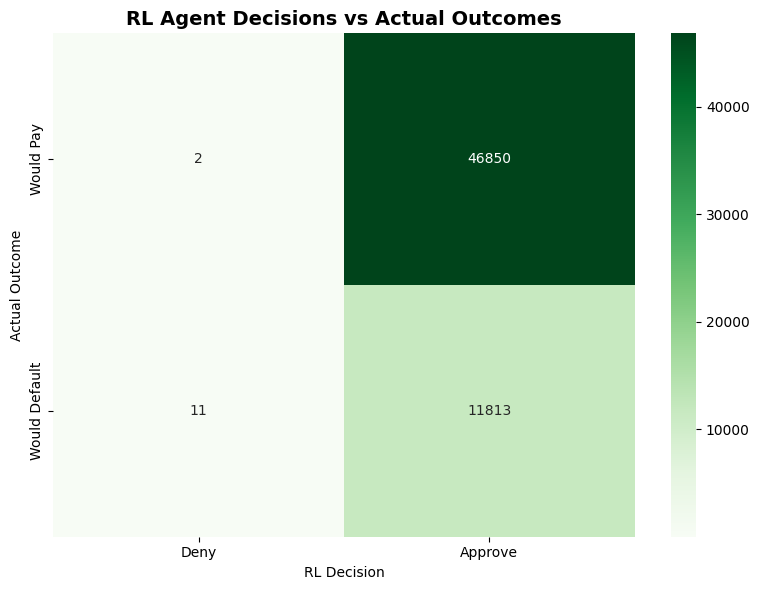

In [36]:
print("\n" + "="*80)
print("ANALYZING RL POLICY")
print("="*80)

# Create comparison dataframe
rl_results = pd.DataFrame({
    'true_default': test_labels,
    'rl_action': rl_actions,
    'loan_amount': test_loan_amts,
    'interest_rate': test_int_rates,
    'actual_reward': test_rewards,
    'policy_reward': policy_rewards
})

# Save RL predictions
rl_results.to_csv('C:/Users/AKANKSHA SINHA/Desktop/Shodhai/results/rl_predictions.csv', index=False)
print("Saved RL predictions to: results/rl_predictions.csv")

# Analyze approval rates by actual outcome
print("\nApproval rates by actual loan outcome:")
approval_by_outcome = rl_results.groupby('true_default')['rl_action'].agg(['mean', 'count'])
approval_by_outcome.columns = ['Approval_Rate', 'Count']
print(approval_by_outcome)

# Confusion matrix (treating RL action as prediction)
cm = confusion_matrix(test_labels, rl_actions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Deny', 'Approve'],
            yticklabels=['Would Pay', 'Would Default'])
plt.title('RL Agent Decisions vs Actual Outcomes', fontsize=14, fontweight='bold')
plt.ylabel('Actual Outcome')
plt.xlabel('RL Decision')
plt.tight_layout()
plt.savefig('C:/Users/AKANKSHA SINHA/Desktop/Shodhai/results/rl_confusion_matrix.png', dpi=300)
print("\nSaved: rl_confusion_matrix.png")


In [37]:
metrics = {
    'policy_value_per_loan': float(policy_value),
    'total_policy_value': float(total_policy_value),
    'baseline_value_per_loan': float(baseline_value),
    'total_baseline_value': float(total_baseline_value),
    'improvement_percent': float(improvement),
    'approval_rate': float((rl_actions == 1).mean()),
    'denial_rate': float((rl_actions == 0).mean())
}

with open('C:/Users/AKANKSHA SINHA/Desktop/Shodhai/results/rl_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print("\nSaved metrics to: results/rl_metrics.json")

print("\n" + "="*80)
print("OFFLINE RL AGENT TRAINING COMPLETE!")
print("="*80)
print(f"Policy Value: ${policy_value:,.2f} per loan")
print(f"Improvement: {improvement:+.2f}%")


Saved metrics to: results/rl_metrics.json

OFFLINE RL AGENT TRAINING COMPLETE!
Policy Value: $-1,478.60 per loan
Improvement: +0.14%
